In [467]:
import cv2
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import face_recognition
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [468]:
# Load the model
model = load_model('best_model-b7-first.h5')

In [469]:
detector = MTCNN()
img_size = 128

video_path = './data/train_sample_videos/bpwzipqtxf.mp4'

In [470]:
def read_frame(cap, sec):    
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    has_frame, image = cap.read()
    
    num_faces = 0
    faces_images = []

    if has_frame:
        # Find faces
        faces = detector.detect(image)
        if faces[0] is not None:
            num_faces = len(faces[0])
        if num_faces > 0:
            for i in range(num_faces):
                try:
                    accuracy = faces[1][i]
                    if(accuracy > 0.90):
                        x1 = int(faces[0][i][0])
                        y1 = int(faces[0][i][1])
                        x2 = int(faces[0][i][2])
                        y2 = int(faces[0][i][3])

                        # Add 20 % padding to each side of the face
                        padding_x = int((x2 - x1) * 0.2)
                        padding_y = int((y2 - y1) * 0.2)
                        
                        x1 = x1 - padding_x
                        y1 = y1 - padding_y
                        x2 = x2 + padding_x
                        y2 = y2 + padding_y

                        # Ensure we're inside 
                        x1 = max(0, x1)
                        y1 = max(0, y1)
                        x2 = min(image.shape[1], x2)
                        y2 = min(image.shape[0], y2)

                        face_image = image[y1-padding_y:y2+padding_y, x1-padding_x:x2+padding_x]

                        face_image = cv2.resize(face_image, (img_size, img_size))
                        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                        faces_images.append(face_image)
                except:
                    pass

    return has_frame, faces_images, num_faces


def get_all_faces_from_video(path):
    cap = cv2.VideoCapture(path)

    images = []
    max_faces = 0

    sec = 0
    frame_rate = 0.5 # Clips is about 10 seconds giving us 10 frame for each video
    success = True
    while success:
        success, faces_images, num_faces = read_frame(cap, sec)
        sec += frame_rate

        if(success):
            for face_image in faces_images:
                if face_image is not None:
                    images.append(face_image)

            if num_faces > max_faces:
                max_faces = num_faces

    return images, max_faces


faces_images, num_faces = get_all_faces_from_video(video_path)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


## Do the clustering

In [471]:
# Encode faces
faces_encodings = []
indexes = []
for i, face in enumerate(faces_images):
    face_encoding = face_recognition.face_encodings(face)
    if len(face_encoding) > 0:
        faces_encodings.append(face_encoding[0])
        indexes.append(i)

In [472]:
from sklearn.cluster import KMeans
clt = KMeans(n_clusters=num_faces)
clt.fit(faces_encodings)
clt.labels_

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

In [473]:
# Find all faces in the same cluster
clusters = []
for label in set(clt.labels_):
    # Get indexes of faces in the cluster
    indexes = [i for i, x in enumerate(clt.labels_) if x == label]
    # Get images in the cluster
    faces = [faces_images[i] for i in indexes]
    # Add to clusters
    clusters.append(faces)

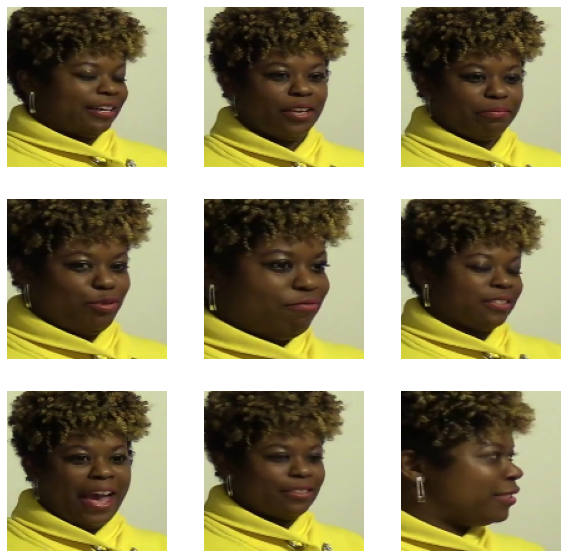

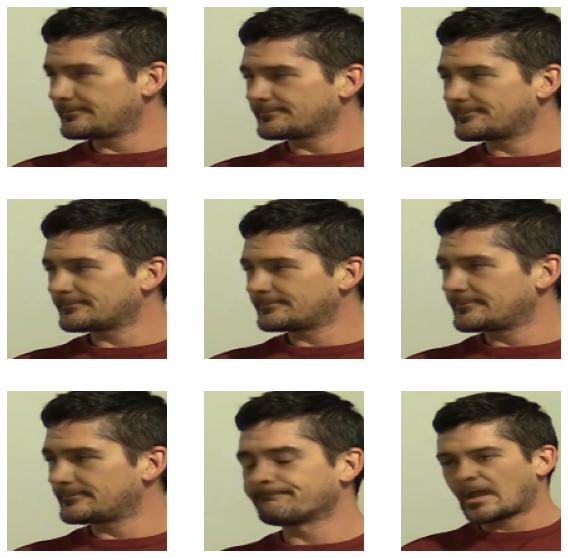

In [474]:
for cluster in clusters:
    plt.figure(figsize=(10, 10))
    for d in range(min(9, len(cluster))):
        plt.subplot(3, 3, d+1)
        plt.imshow(cluster[d])
        plt.axis('off')

In [475]:
image_data_generator = ImageDataGenerator(
    rescale = 1/255
)

# Create one generator for each cluster
result = 0
for i in range(len(clusters)):
    generator = image_data_generator.flow(np.reshape(clusters[i], (np.shape(clusters[i]))) , batch_size=1, seed=1)
    predictions = model.predict(generator)
    # Calculate the average prediction
    average = 1 - np.mean(predictions[i], axis=0)
    if average > result:
        result = average
result

0.9328758120536804